In [1]:
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
from scipy import optimize as op
from jax import config
import jax.random as jrandom
from time import time

config.update("jax_enable_x64", True)

In [29]:
sigma_x = 0.01
sigma_t = 0.01

x_values = jnp.arange(0, 2, sigma_x)
t_values = jnp.arange(0, 2, sigma_t)
v = 0.001
sigma_t = 0.001  # smaller time step
v = 0.0005  # smaller velocity
N = len(x_values)
M = len(t_values)

In [ ]:
key = jrandom.PRNGKey(int(time()))
mean = 0
std_dev = 0.05
Z = jrandom.normal(key, shape=(200,)) * std_dev + mean
u = jnp.sin(x_values * 2 * math.pi) + 2 * Z
f = jnp.cos(x_values * 4 * math.pi)
nu = jnp.zeros(x_values.shape)
x_0 = jnp.expand_dims(jnp.r_[u, f, u, f, nu], axis=-1)

In [31]:
A = -2 * jnp.ones(x_values.shape[0])
A = jnp.diag(A)
A += jnp.diag(jnp.ones(x_values.shape[0] - 1), k=-1) + jnp.diag(
    jnp.ones(u.shape[0] - 1), k=1
)
A /= sigma_x**2


In [32]:
B = jnp.diag(jnp.ones(N - 1), k=-1) + jnp.diag(jnp.ones(N - 1), k=1)
B /= 2 * sigma_x

In [33]:
INVS = jnp.linalg.inv(jnp.eye(A.shape[0]) - 0.5 * sigma_t * v * A)

In [34]:
def new_u(
    u: jnp.ndarray, f: jnp.ndarray, prev_u: jnp.ndarray, prev_f: jnp.ndarray, v: float
) -> jnp.ndarray:
    new_u = INVS
    temp = (jnp.eye(A.shape[0]) - 0.5 * sigma_t * v * A) @ u

    temp -= sigma_t * B @ (1.5 * u**2 - 0.5 * prev_u**2)
    temp += sigma_t * (1.5 * f - 0.5 * prev_f)
    new_u @= temp
    return new_u

In [35]:
def new_u(u, f, prev_u, prev_f, v):
    # system matrix for implicit part
    F = (
        jnp.eye(N)
        + 0.5 * sigma_t * v * A
        - 3 * sigma_t * B @ jnp.diag(u.squeeze())
        + 0.5 * sigma_t * B @ jnp.diag(prev_u.squeeze())
    )

    # right-hand side G
    G = (
        (jnp.eye(N) - 0.5 * sigma_t * v * A) @ u
        - sigma_t * B @ (1.5 * u**2 - 0.5 * prev_u**2)
        + sigma_t * (1.5 * f - 0.5 * prev_f)
    )

    # solve F u_next = G
    return jnp.linalg.solve(F, G)


In [ ]:
def new_state(
    x_k: jnp.ndarray,
    __: jnp.ndarray = None,
) -> jnp.ndarray:
    start = 0
    end = u.shape[0]
    u_k = x_k[start:end]
    start += f.shape[0]
    end += f.shape[0]
    f_k = x_k[start:end]
    start += u.shape[0]
    end += u.shape[0]
    prev_u_k = x_k[start:end]
    start += f.shape[0]
    end += f.shape[0]
    prev_f_k = x_k[start:end]
    nu = x_k[end:]

    # u_k = u_k / jnp.max(jnp.abs(u_k)+1e-6)
    # prev_u_k = prev_u_k / jnp.max(jnp.abs(prev_u_k)+1e-6)
    # f_k = f_k / jnp.max(jnp.abs(f_k)+1e-6)
    # prev_f_k = prev_f_k / jnp.max(jnp.abs(prev_f_k)+1e-6)

    new_x = jnp.r_[new_u(u_k, f_k, prev_u_k, prev_f_k, v), f_k, u_k, f_k, nu]
    return new_x

In [37]:
def jaccobian_f(x_k: jnp.ndarray) -> jnp.ndarray:
    Fuu = (
        jnp.eye(A.shape[0])
        + 0.5 * sigma_t * v * A
        - 3 * B @ jnp.diag(x_k[: A.shape[0]].squeeze()) * sigma_t
    )
    Fuu += 0.5 * B @ jnp.diag(x_k[A.shape[0] : 2 * A.shape[0]].squeeze()) * sigma_t
    # Fuu @= INVS
    Fuu = jnp.linalg.solve(Fuu, jnp.eye(N) - 0.5 * sigma_t * v * A)
    eye = jnp.eye(f.shape[0])
    zero = jnp.zeros(A.shape)

    Fuf = jnp.eye(f.shape[0]) * sigma_t

    F = jnp.block(
        [
            [Fuu, Fuf, zero, zero, zero],
            [zero, eye, zero, zero, zero],
            [zero, zero, eye, zero, zero],
            [zero, zero, zero, eye, zero],
            [zero, zero, zero, zero, eye],
        ]
    )
    return F

In [38]:
def jaccobian_f(x_k: jnp.ndarray) -> jnp.ndarray:
    N = A.shape[0]
    total_len = x_k.shape[0]

    # extract blocks (match new_state ordering)
    u_k = x_k[0:N].squeeze()
    f_k = x_k[N : 2 * N].squeeze()
    prev_u_k = x_k[2 * N : 3 * N].squeeze()
    prev_f_k = x_k[3 * N : 4 * N].squeeze()
    # nu = x_k[4*N:]  # not used

    I_N = jnp.eye(N)

    # compute u_next (must be same new_u used by forward step)
    u_next = new_u(u_k, f_k, prev_u_k, prev_f_k, v)  # shape (N,)

    # Build F (matrix used in forward solve)
    F = (
        I_N
        + 0.5 * sigma_t * v * A
        - 3.0 * sigma_t * (B @ jnp.diag(u_k))
        + 0.5 * sigma_t * (B @ jnp.diag(prev_u_k))
    )

    # invert F (use solve for stability)
    FINV = jnp.linalg.solve(F, I_N)  # F^{-1}

    # diag matrices
    diag_3u = jnp.diag(3.0 * u_k)
    diag_prev_u = jnp.diag(prev_u_k)
    diag_unext = jnp.diag(u_next.squeeze())

    # compute blocks according to derived expressions
    U_inner = (
        I_N
        - 0.5 * sigma_t * v * A
        - sigma_t * (B @ diag_3u)
        + 3.0 * sigma_t * (B @ diag_unext)
    )
    U_block = FINV @ U_inner

    F_block = FINV * (1.5 * sigma_t)  # FINV @ (1.5 σ_t I)
    PrevU_block = FINV @ (
        sigma_t * (B @ diag_prev_u) - 0.5 * sigma_t * (B @ diag_unext)
    )
    PrevF_block = FINV * (-0.5 * sigma_t)  # FINV @ (-0.5 σ_t I)

    # assemble full Jacobian with same block-row ordering as new_state -> new_x = [new_u, f_k, u_k, f_k, nu]
    nu_len = total_len - 4 * N
    zero_NN = jnp.zeros((N, N))
    zero_N_nu = jnp.zeros((N, nu_len))

    first_row = jnp.concatenate(
        [U_block, F_block, PrevU_block, PrevF_block, zero_N_nu], axis=1
    )
    row2 = jnp.concatenate(
        [zero_NN, jnp.eye(N), jnp.zeros((N, N)), jnp.zeros((N, N)), zero_N_nu], axis=1
    )
    row3 = jnp.concatenate(
        [
            jnp.eye(N),
            jnp.zeros((N, N)),
            jnp.zeros((N, N)),
            jnp.zeros((N, N)),
            zero_N_nu,
        ],
        axis=1,
    )
    row4 = jnp.concatenate(
        [
            jnp.zeros((N, N)),
            jnp.eye(N),
            jnp.zeros((N, N)),
            jnp.zeros((N, N)),
            zero_N_nu,
        ],
        axis=1,
    )

    if nu_len > 0:
        row5 = jnp.concatenate(
            [
                jnp.zeros((nu_len, N)),
                jnp.zeros((nu_len, N)),
                jnp.zeros((nu_len, N)),
                jnp.zeros((nu_len, N)),
                jnp.eye(nu_len),
            ],
            axis=1,
        )
        Fbig = jnp.vstack([first_row, row2, row3, row4, row5])
    else:
        Fbig = jnp.vstack([first_row, row2, row3, row4])

    return Fbig


In [39]:
def h(x: jnp.ndarray) -> jnp.ndarray:
    block = jnp.block(
        [
            jnp.eye(A.shape[0]),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
        ]
    )
    return block @ x


In [40]:
def jaccobian_h(x: jnp.ndarray) -> jnp.ndarray:
    block = jnp.block(
        [
            jnp.eye(A.shape[0]),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
        ]
    )
    return block


In [41]:
steps = 6

In [42]:
def all_states(x0: jnp.ndarray, f: callable, steps: int) -> list:
    states = [x0]
    for step in range(1, steps):
        states.append(f(states[step - 1]))
    return states

In [43]:
def all_errors(states: list, true_states: jnp.ndarray, h: callable) -> jnp.ndarray:
    return jnp.array(list(map(h, jnp.array(states)))) - true_states


def all_errors1(states, true_states, h) -> jnp.ndarray:
    preds = jnp.stack([h(s).ravel() for s in states])
    return preds - true_states

In [ ]:
def adjoint_gradient(
    x0: jnp.ndarray,
    steps: int,
    true_states: jnp.ndarray,
    f: callable,
    h: callable,
    jaccobian_f: callable,
    jaccobian_h: callable,
) -> jnp.ndarray:
    states = all_states(x0, f, steps)
    errors = all_errors(jnp.array(states), true_states, h)

    lam = jaccobian_h(states[-1]).T @ errors[-1]
    for t in range(steps - 2, -1, -1):
        Ft = jaccobian_f(states[t])
        Ht = jaccobian_h(states[t])
        lam = Ft.T @ lam + Ht.T @ errors[t]

    return lam.ravel()


In [45]:
def objective(x0):
    states = all_states(x0, new_state, steps)
    errors = all_errors(jnp.array(states), u, h)
    return 0.5 * jnp.sum(errors**2)


def gradient(x0):
    return adjoint_gradient(
        x0, steps, u, new_state, h, jaccobian_f, jaccobian_h
    ).reshape((1000,))

In [49]:
res = op.minimize(
    objective,
    jnp.zeros_like(x_0.reshape((1000,))),
    # x_0.reshape((1000,)),
    args=(),
    method="L-BFGS-B",
    jac=gradient,
    bounds=None,
    tol=None,
    callback=None,
    options={"maxls": 40, "ftol": 1e-8, "gtol": 1e-8, "disp": True},
)

In [50]:
res

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0012631939856805577
        x: [-1.629e-02  1.517e-01 ...  0.000e+00  0.000e+00]
      nit: 5120
      jac: [-4.154e-06 -9.761e-06 ...  0.000e+00  0.000e+00]
     nfev: 5252
     njev: 5252
 hess_inv: <1000x1000 LbfgsInvHessProduct with dtype=float64>

In [ ]:
import pickle


# with open("res.pkl", "wb") as f:
#    pickle.dump(res, f)
with open("res.pkl", "rb") as x:
    loaded_data = pickle.load(x)

print(loaded_data)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.007125537487685277
        x: [-7.292e-03  5.601e-02 ...  0.000e+00  0.000e+00]
      nit: 6630
      jac: [ 2.280e-05  2.552e-05 ...  0.000e+00  0.000e+00]
     nfev: 6797
     njev: 6797
 hess_inv: <1000x1000 LbfgsInvHessProduct with dtype=float64>


In [52]:
final_states = all_states(res.x, new_state, steps)
final_errors = all_errors(jnp.array(final_states), u, h)
rmse = jnp.sqrt(jnp.mean(final_errors**2))
print("Final RMSE:", rmse)

Final RMSE: 0.0014509732283772834


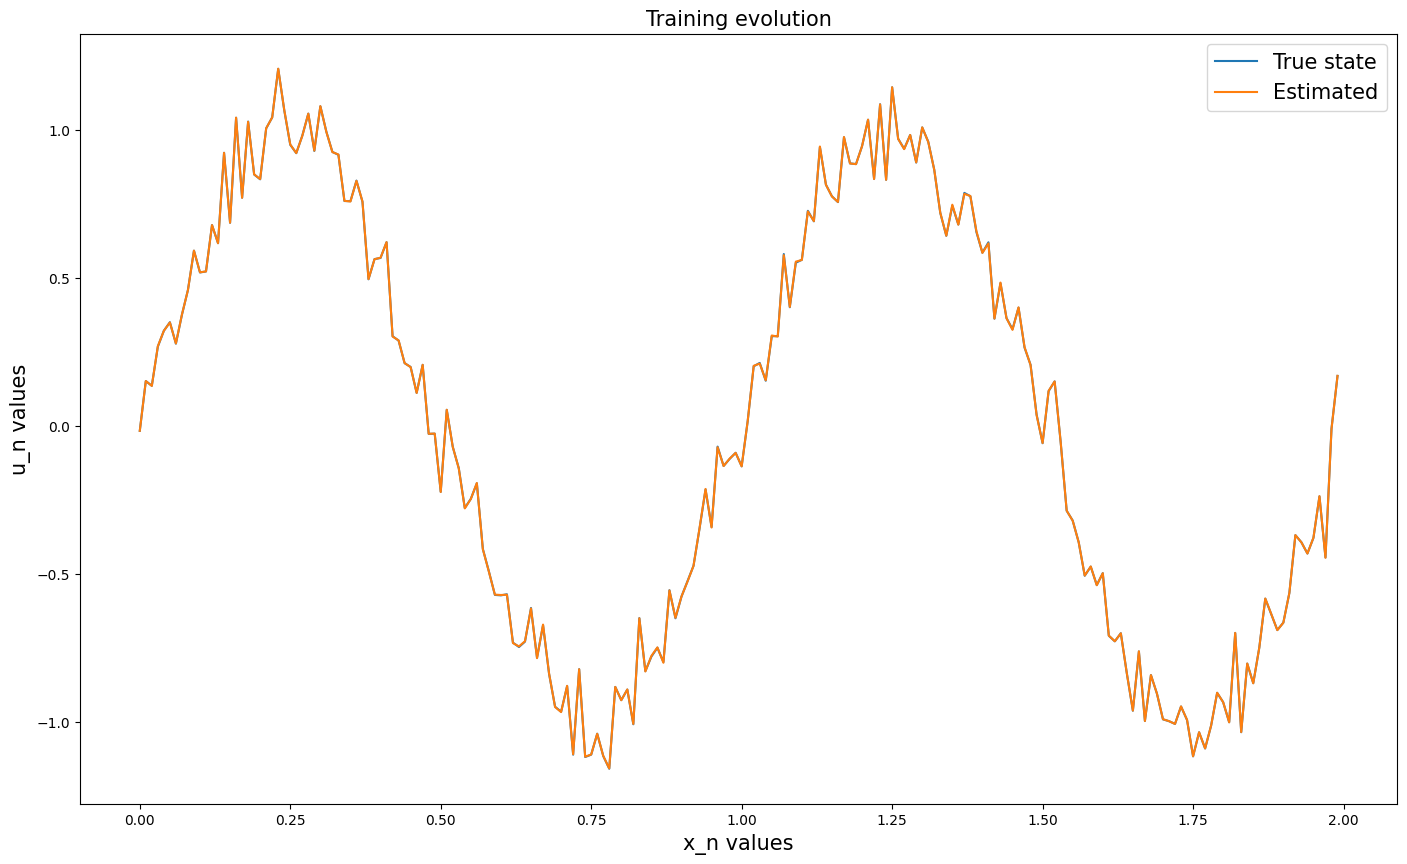

In [51]:
fig, ax = plt.subplots()
ax.plot(x_values, x_0[:N], label="True state")
plt.plot(x_values, res.x[:200,], label="Estimated")
plt.xlabel("x_n values", fontsize=15)
plt.ylabel("u_n values", fontsize=15)
plt.title("Training evolution", fontsize=15)
ax.legend(fontsize=15)
fig.set_size_inches(17, 10, forward=True)
plt.show()

In [24]:
final_states = all_states(loaded_data.x, new_state, steps)
final_errors = all_errors(jnp.array(final_states), u, h)
rmse = jnp.sqrt(jnp.mean(final_errors**2))
print("Final RMSE:", rmse)

Final RMSE: 0.14799603805787784


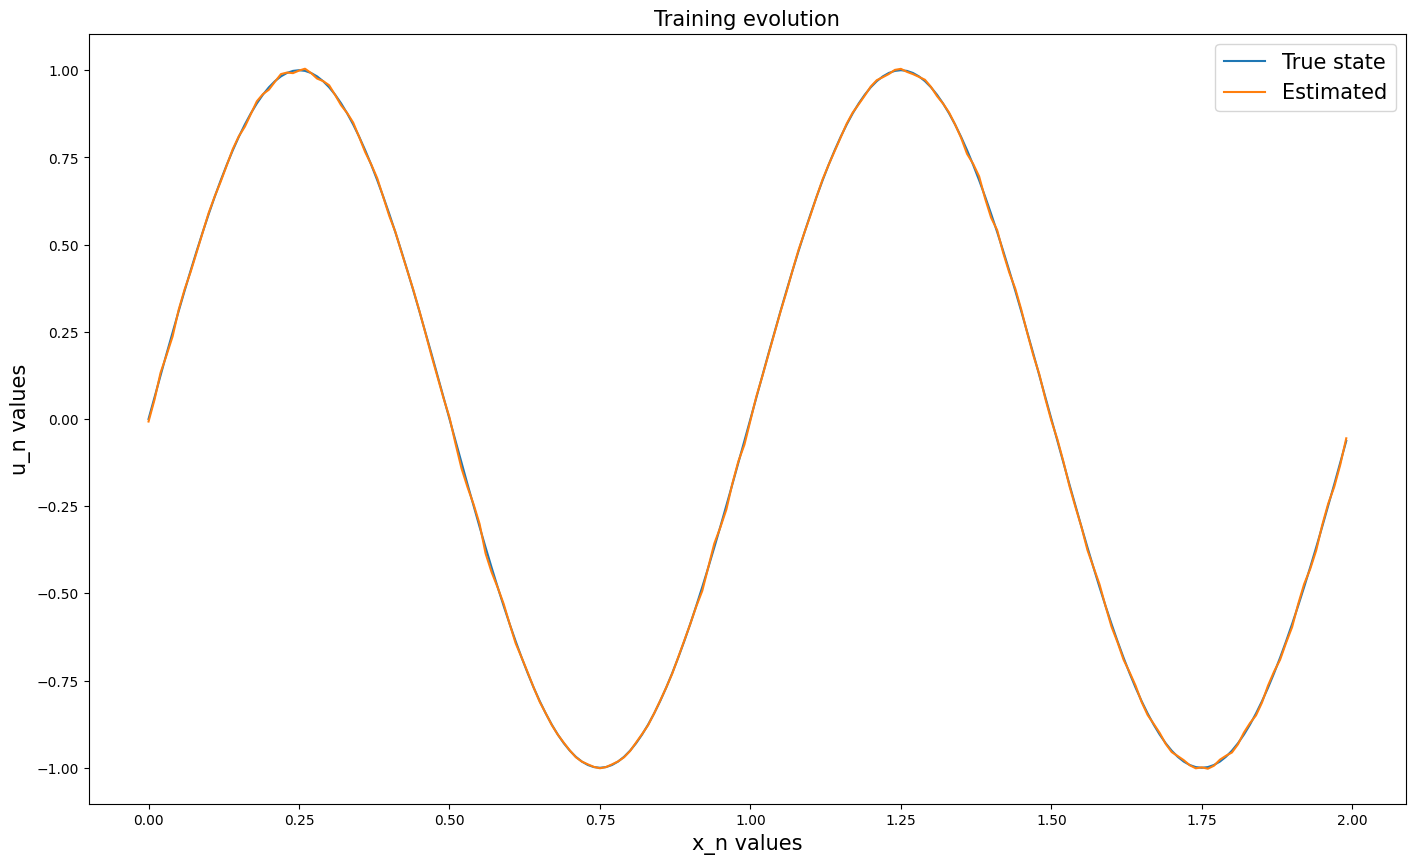

In [25]:
fig, ax = plt.subplots()
ax.plot(x_values, x_0[:N], label="True state")
plt.plot(x_values, loaded_data.x[:200,], label="Estimated")
plt.xlabel("x_n values", fontsize=15)
plt.ylabel("u_n values", fontsize=15)
plt.title("Training evolution", fontsize=15)
ax.legend(fontsize=15)
fig.set_size_inches(17, 10, forward=True)
plt.show()